In [24]:
import numpy as np
import pandas as pd

from importlib import reload

import synthetic.render.generator as gen

import matplotlib.pyplot as plt
%matplotlib inline

import multiprocessing as mp

import sys
import os
import math
import logging
import time
import galsim
import fitsio as fio

import ngmix

import synthetic.render.render as render
import synthetic.render.icl as icl
import images

# create raw canvas

In [2]:
catalog_path = '/e/ocean1/users/vargatn/DES/SIM_DATA/SKY_MODEL_EPSILON/res_clust_v2_z0l0/epsilon_clust_v8-z0l0_15000_000.fits'
catalog = fio.read(catalog_path)
catalog_cluster = catalog[catalog['LOC'] == 1]
catalog_field = catalog[catalog['LOC'] == 0]

In [3]:
df = render.DrawField(5000, catalog_cluster, band="z")

In [4]:
df.prepare()
df.make_infodicts()
df.multi_render(10)
df.collate_stamps()

starting xshear calculations in 10 processes


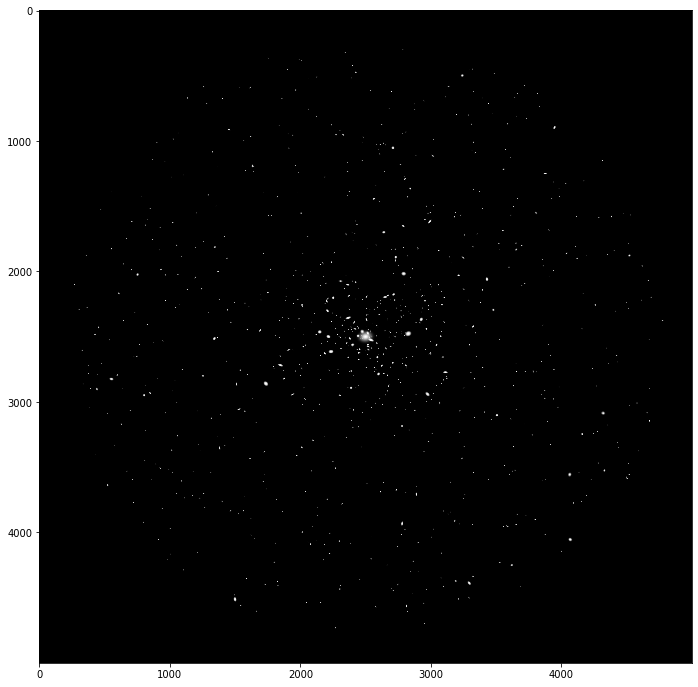

In [5]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array + 0.001
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)


# Add ICL

In [6]:
galpath = "./ICL/evolving_red_gal.dat"
mstarpath = "./ICL/mstar_des_i03.fit"
jk_profile_root = "./ICL/jacknife_profiles_0.15_rand_back_subtracted_corZ_faintgalsub/jacknife_profile_"

bcg = {
    "size": 32.,
    "g1": 0.1356766444194723,
    "g2":-0.0345231539560347,
    "imag": 17.76,
    "color_gr": 1.36,
    "color_ri": 0.54,
    "color_iz": 0.32,
}
mass = 10**14.45
z = 0.3

In [7]:
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)

In [8]:
di.get_icl()

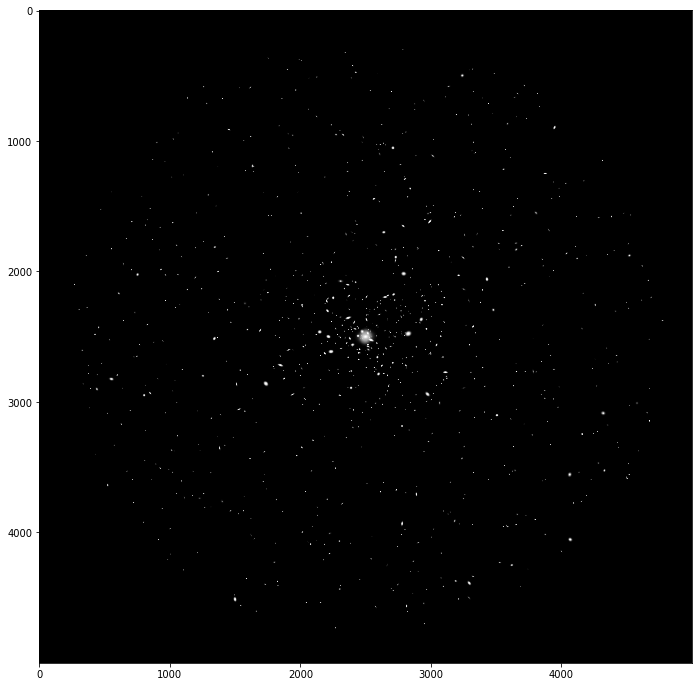

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array + di.flux_z
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)

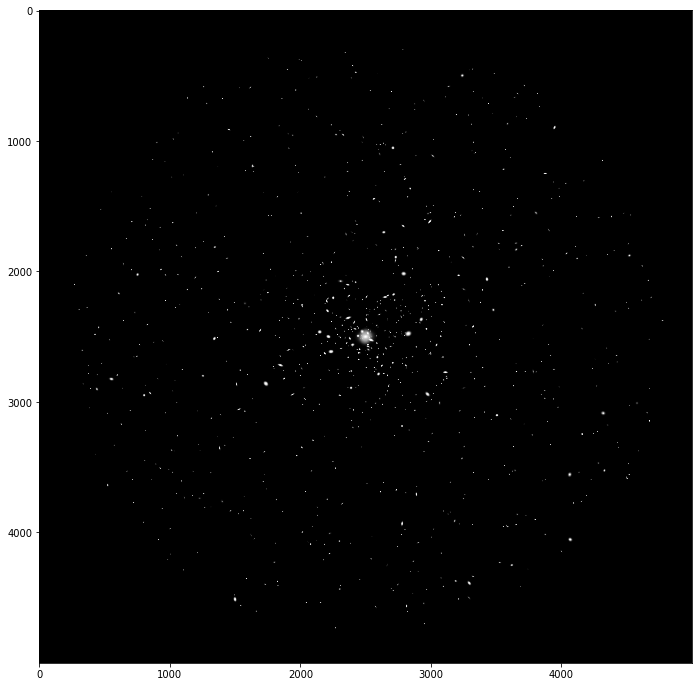

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = df.canvas.array + di.flux_z
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)

# Color composit images

In [11]:
reload(render)

<module 'synthetic.render.render' from '/home/moon/vargatn/DES/SYNTHETIC/synthetic/synthetic/render/render.py'>

In [34]:
arrs = []
arrs2 = []
for band in ["g", "r", "i"]:
    df = render.DrawField(5000, catalog_cluster, band=band)
    df.render()
    arrs.append(df.canvas.array)
    
di = icl.DrawICL(mass, z, bcg, galpath, mstarpath, jk_profile_root)
di.get_icl()
arrs2 = [di.flux_g, di.flux_r, di.flux_i, di.flux_z]

starting xshear calculations in 10 processes
starting xshear calculations in 10 processes
starting xshear calculations in 10 processes


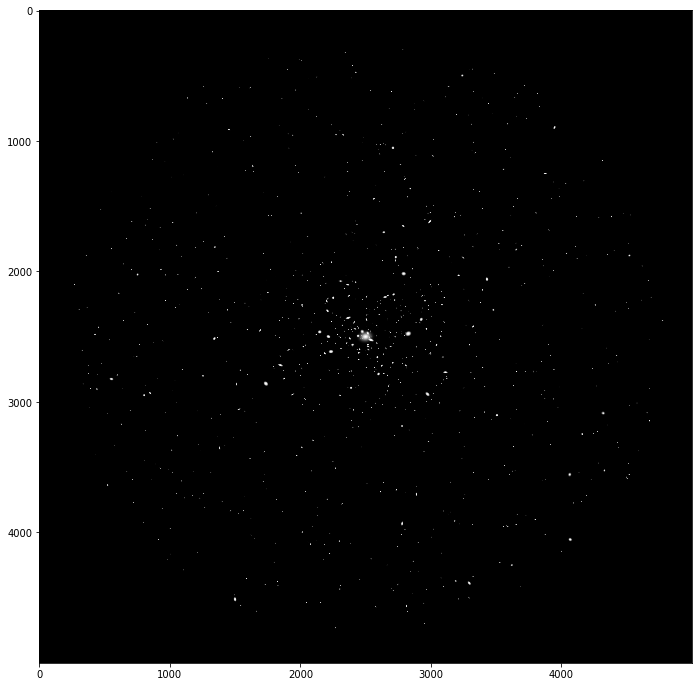

In [32]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cc = arrs[2] + 0.001
ax.imshow(np.arcsinh(cc) / cc, cmap=plt.cm.gray_r)

In [42]:
noises = [
    np.random.normal(scale=0.1, size=(5000, 5000)),
    np.random.normal(scale=0.12, size=(5000, 5000)),
    np.random.normal(scale=0.25, size=(5000, 5000))
]

1.0
example.png


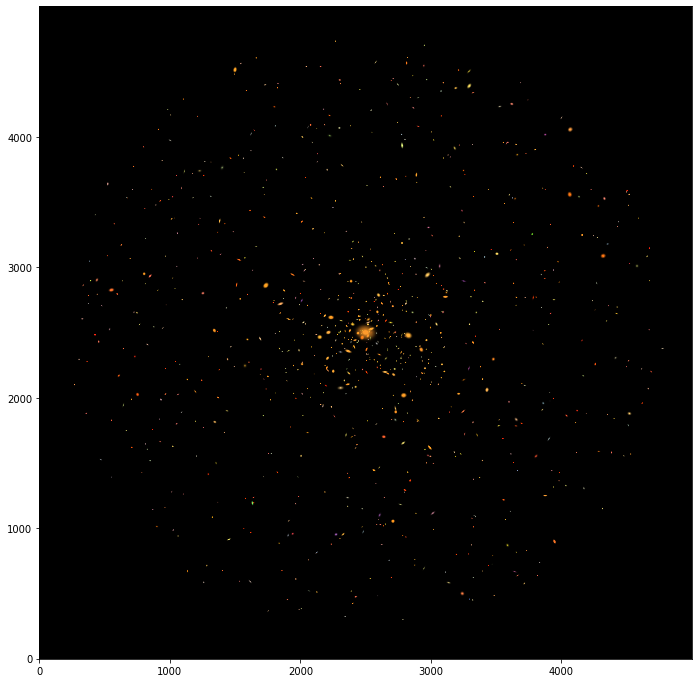

In [46]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 1
scales = np.array([1., 1, 1]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(arrs[2] + pad,
                                arrs[1] + pad,
                                arrs[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * factor, origin=3)
# fig.savefig("mock_clusters_z0l1_{:}.pdf", dpi=300, bbox_inches="tight")
fname = "example.png"
print(fname)
fig.savefig(fname, dpi=300, bbox_inches="tight")

1.0
example.png


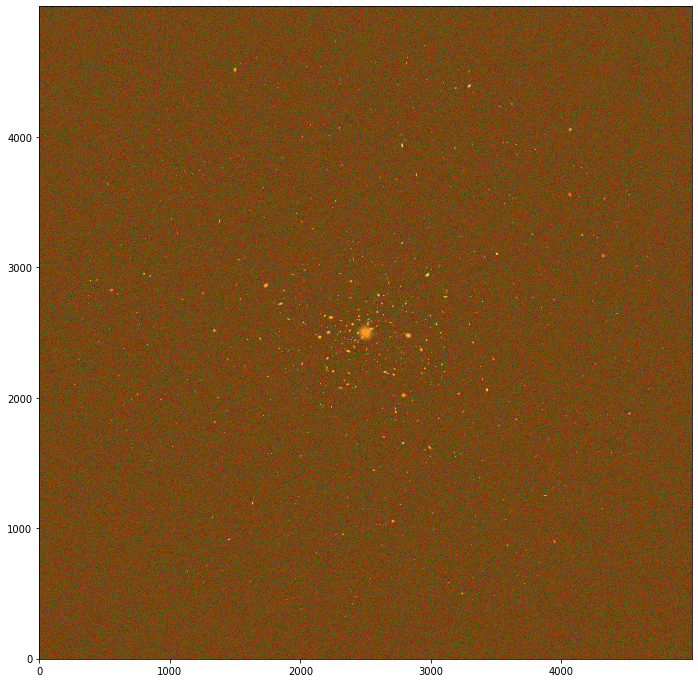

In [45]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
factor = 1
scales = np.array([1., 1, 1]) * factor
nonlinear = 0.12
clip = 0

pad = 0
obs_im = images.get_color_image(arrs[2] + arrs2[2] + noises[2] + pad,
                                arrs[1] + arrs2[1] + noises[1] + pad,
                                arrs[0] + arrs2[0] + noises[0] + pad,
                                nonlinear=nonlinear, clip=clip, scales=scales)  
print(obs_im.max())
ax.imshow(obs_im * factor, origin=3)
# fig.savefig("mock_clusters_z0l1_{:}.pdf", dpi=300, bbox_inches="tight")
fname = "example2.png"
print(fname)
fig.savefig(fname, dpi=300, bbox_inches="tight")